# Imports for Simulation and Visualiation

In [1]:
from random import randint, shuffle
import time
import matplotlib.pyplot as plt
import numpy as np

### Class Game
- Attributes
    - PayoffMatrix
        : Payoff Matrix of two player Game
- Methods
    - findSDSE
        : Computes Strong Dominant Strategy Equilibrium if it exists.
    - findMSNE
        : Computes MSNE using indifference priciple.

In [2]:
class game:
    def __init__(self):
        food = (MAX_FOOD_PER_ROUND + MIN_FOOD_PER_ROUND)//2
        self.payoffMatrix = [ 
                            [[(food//2) - ENERGY_LOSS_FROM_FIGHTING, (food//2) - ENERGY_LOSS_FROM_FIGHTING],[food,0]],
                            [[0, food],[(food//2), (food//2)]]
                            ]
#     Arguments : None, Return: list of SDSE strategy
    def findSDSE(self):
        P1 = []
        P2 = []
        if self.payoffMatrix[0][0][0] > self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] > self.payoffMatrix[1][1][0]:
            P1.append(0)
        if self.payoffMatrix[0][0][0] < self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] < self.payoffMatrix[1][1][0]:
            P1.appendp(1)
        if self.payoffMatrix[0][0][1] > self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] > self.payoffMatrix[1][1][1]:
            P2.append(0)
        if self.payoffMatrix[0][0][1] < self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] < self.payoffMatrix[1][1][1]:
            P2.append(1)
        ret = [(x, y) for x in P1 for y in P2]
        return ret

#   Arguments: None, Return list of probability distribution over strategy for player 1 and player 2
    def findMSNE(self):

        SDSE = self.findSDSE()
        p = np.zeros(2)
        q = np.zeros(2)
        if(len(SDSE) > 0):
            p[SDSE[0][0]] = 1
            q[SDSE[0][1]] = 1
            return [p,q]
        
#         row player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][0] - self.payoffMatrix[1][0][0], self.payoffMatrix[0][1][0] - self.payoffMatrix[1][1][0]] ])
        b = np.array([1, 0])
        q = np.linalg.solve(a, b)
        
#         col player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][1] - self.payoffMatrix[0][1][1], self.payoffMatrix[1][0][1] - self.payoffMatrix[1][1][1]] ])
        b = np.array([1, 0])
        p = np.linalg.solve(a, b) 
        return [p,q]
        

#### Global intitial Condtion
1. STARTING_DOVES
    : The number of players who are Doves in the beginning
2. STARTING_HAWKS
    : The number of players who are Doves in the beginning
3. ROUNDS
    : Number of Rounds in the simulation
4. STARTING_ENERGY
    : The amount of energy with which each player starts the game.
5. MIN_FOOD_PER_ROUND
    : Min energy available per food.
6. MAX_FOOD_PER_ROUND
    : Max energy available per food.
7. MAX_FOOD_APPEARANCE
    : Max number of food appearance per round
8. ENERGY_REQUIRED_FOR_REPRODUCTION
    : Minimum energy required to reproduce
9. ENERGY_LOSS_PER_ROUND
    : Energy spent for surviving a round
10. ENERGY_LOSS_FROM_FIGHTING
    : Energy spent over fighting
11. ENERGY_REQUIRED_FOR_LIVING
    : Minimum energy required to remain alive
    
#### Model Formulation

Game Starts with gameInit(), a function which initialize all the agents. These agents are the players in this game and they can be either HAWK or DOVE. 

In [3]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 250
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 70
MAX_FOOD_PER_ROUND = 70
MAX_FOOD_APPEARANCE = 2000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 80
ENERGY_REQUIRED_FOR_LIVING = 10

STATUS_ACTIVE = "active"
STATUS_ASLEEP = "asleep"

TYPE_HAWK = "hawk"
TYPE_DOVE = "dove"

agents = []

# Graph stuff
graph_hawk_points = []
graph_dove_points = []

AGENT_ID = 1
class Agent:
    
    def __init__(self, agent_type, status, energy):
        global AGENT_ID
        self.id = AGENT_ID
        AGENT_ID += 1
        self.agent_type = agent_type
        self.status = status
        self.energy = energy
    def wake(self):
        self.status = STATUS_ACTIVE
    def sleep(self):
        self.status = STATUS_ASLEEP

def gameInit():
    global agents
    agents = []
    for x in range(0,STARTING_DOVES):
        a = Agent(TYPE_DOVE, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)
    for x in range(0,STARTING_HAWKS):
        a = Agent(TYPE_HAWK, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)

def compete(agent, nemesis, food):
# add a food fuction inside agent
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_HAWK:
        # food distributed as food // 2 and loss from fighting subtracted
        agent.energy += (food//2)
        agent.energy -= ENERGY_LOSS_FROM_FIGHTING
        nemesis.energy += (food//2)
        nemesis.energy -= ENERGY_LOSS_FROM_FIGHTING
        
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_DOVE:
        agent.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_HAWK:
        nemesis.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_DOVE:
        agent.energy += (food//2)
        nemesis.energy += (food//2)

    nemesis.sleep()
    agent.sleep()
def cull():

    dead_hawks = 0
    dead_doves = 0
    n = len(agents)
    for index, agent in enumerate(reversed(agents)):
        if agent.energy < ENERGY_REQUIRED_FOR_LIVING:
            if agent.agent_type == TYPE_DOVE: dead_doves += 1
            if agent.agent_type == TYPE_HAWK: dead_hawks += 1
            del agents[n - index - 1]


    return dead_hawks, dead_doves
def breed():
    """
    If agent can breed, it halves its energy and produces 
    one baby with starting energy (parent energy // 2) and
    keep parent energy // 2 for itself
    """
    hawk_babies = 0
    dove_babies = 0
    for agent in agents:
        if agent.energy > ENERGY_REQUIRED_FOR_REPRODUCTION:
            baby_agent_a = Agent(agent.agent_type, STATUS_ASLEEP, (agent.energy//2))
            agents.append(baby_agent_a)

            agent.energy //= 2

            if agent.agent_type == TYPE_DOVE: dove_babies += 1
            if agent.agent_type == TYPE_HAWK: hawk_babies += 1


    return hawk_babies, dove_babies
def getCountOfType(agents):
    local_hawk_count = 0
    local_dove_count = 0
    for agent in agents:
        if agent.agent_type == TYPE_HAWK:
            local_hawk_count += 1
        else:
            local_dove_count += 1
    return local_hawk_count, local_dove_count
def getFood():
    return randint(MIN_FOOD_PER_ROUND, MAX_FOOD_PER_ROUND)
def awakenAgents():
    for agent in agents:
        agent.wake()
def main():
    gameInit()

    current_round = 1
    death_count = 0
    dead_hawks  = 0
    dead_doves  = 0
    breed_count = 0
    main_tic = time.time()
    
    while current_round <= ROUNDS and len(agents) > 2:
        print(f"Round {current_round}")
        tic = time.time()
        awakenAgents()
        food = getFood()
# shuffling agents so that the matchmaking while be random
        shuffle(agents)
        for idx in range (0, len(agents), 2):
            if idx//2 > MAX_FOOD_APPEARANCE:
                break
            if idx + 1 >= len(agents):
                break
            agent, nemesis = agents[idx], agents[idx + 1]
            compete(agent, nemesis, food)

        # Energy cost of 'living'
        for agent in agents:
            agent.energy -= ENERGY_LOSS_PER_ROUND
        
        round_dead_hawks, round_dead_doves = cull()
        round_hawk_babies, round_dove_babies = breed()
        death_count += (round_dead_hawks + round_dead_doves)
        breed_count += (round_hawk_babies + round_dove_babies)


        toc = time.time()
        # Plot
        hawk_count, dove_count = getCountOfType(agents)
        hawk_percent = (hawk_count / (hawk_count + dove_count))*100
        dove_percent = (dove_count / (hawk_count + dove_count))*100
        graph_hawk_points.append(hawk_count)
        graph_dove_points.append(dove_count)
        print("ROUND %d" % current_round)
        print("Food produced          : %d" % food)
        print(f"Population             : Hawks-> {hawk_count}, Doves-> {dove_count}")
        print("Dead hawks             : %d" % round_dead_hawks)
        print("Dead doves             : %d" % round_dead_doves)
        print("Hawk babies            : %s" % round_hawk_babies)
        print("Dove babies            : %s" % round_dove_babies)
        print("Hawks                  : %s" % hawk_percent)
        print("Doves                  : %s" % dove_percent)
        print("----")
        print("Round Processing time  : %s" % (toc - tic))
        print("Elapsed time           : %s\n" % (time.time() - main_tic))

        

        current_round += 1


    main_toc = time.time()
    hawk_count, dove_count = getCountOfType(agents)
    hawk_percent = (hawk_count / (hawk_count + dove_count))*100
    dove_percent = (dove_count / (hawk_count + dove_count))*100
    print("=============================================================")
    print("Total dead agents      : %d" % death_count)
    print("Total breeding agents  : %d" % breed_count)
    print("Total rounds completed : %d" % (current_round - 1))
    print("Total population size  : %s" % len(agents))
    print("Hawks                  : %s" % hawk_percent)
    print("Doves                  : %s" % dove_percent)
    print("Processing time        : %s" % (main_toc - main_tic))
    print("=============================================================")
main()


Round 1
ROUND 1
Food produced          : 70
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.004948854446411133
Elapsed time           : 0.004948854446411133

Round 2
ROUND 2
Food produced          : 70
Population             : Hawks-> 756, Doves-> 1000
Dead hawks             : 244
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 43.052391799544424
Doves                  : 56.947608200455576
----
Round Processing time  : 0.005983114242553711
Elapsed time           : 0.010931968688964844

Round 3
ROUND 3
Food produced          : 70
Population             : Hawks-> 893, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 137
Dove babies            : 0
Hawks                  : 47.17379820390913

In [4]:
npdove = np.array(graph_dove_points)
nphawk = np.array(graph_hawk_points)
npdovePer = npdove / (npdove + nphawk)
nphawkPer = nphawk / (npdove + nphawk)
nppopulation = nphawk + npdove
nppopulation = nppopulation/np.max(nppopulation)

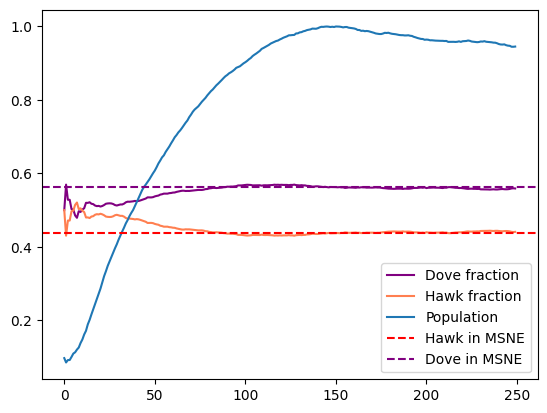

In [5]:
plt.clf()
plt.plot(npdovePer, color = "purple", label = "Dove fraction")
plt.plot(nphawkPer, color = "coral", label = "Hawk fraction")
plt.plot(nppopulation, label = "Population")
MSNE = game().findMSNE()
plt.axhline(y=MSNE[0][0],color = 'red', linestyle='--', label = "Hawk in MSNE")
plt.axhline(y=MSNE[0][1],color = 'purple', linestyle='--', label = "Dove in MSNE")
plt.legend()



plt.show()

In [7]:
print(MSNE)

[array([0.4375, 0.5625]), array([0.4375, 0.5625])]
